# Imports

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import requests
from bs4 import BeautifulSoup
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy import stats

In [ ]:
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

#paths to csv files
path_to_compliance = '/content/drive/My Drive/PTFDS project/compliance lead and copper.csv'
path_to_residential = '/content/drive/My Drive/PTFDS project/residential lead and copper.csv'

Mounted at /content/drive


In [ ]:
# get valid nyc zip codes
try:
  content = requests.get('https://www.nycbynatives.com/nyc_info/new_york_city_zip_codes.php').text
  soup=BeautifulSoup(content,'html')
  zipcodes=[t.text.strip() for t in soup.find_all('td') if t.text != '\xa0'][::2]
  print(zipcodes)
except:
  print("couldn't get zip codes")

['10001', '10451', '10002', '10452', '10003', '10453', '10004', '10454', '10005', '10455', '10006', '10456', '10007', '10457', '10009', '10458', '10010', '10459', '10011', '10460', '10012', '10461', '10013', '10462', '10014', '10463', '10015', '10464', '10016', '10465', '10017', '10466', '10018', '10467', '10019', '10468', '10020', '10469', '10021', '10470', '10022', '10471', '10023', '10472', '10024', '10473', '10025', '10474', '10026', '10475', '10027', '11201', '10028', '11203', '10029', '11204', '10030', '11205', '10031', '11206', '10032', '11207', '10033', '11208', '10034', '11209', '10035', '11210', '10036', '11211', '10037', '11212', '10038', '11213', '10039', '11214', '10040', '11215', '10041', '11216', '10044', '11217', '10045', '11218', '10048', '11219', '10055', '11220', '10060', '11221', '10069', '11222', '10090', '11223', '10095', '11224', '10098', '11225', '10099', '11226', '10103', '11228', '10104', '11229', '10105', '11230', '10106', '11231', '10107', '11232', '10110', 

In order to check if the datasets contain valid NYC zip codes, we scraped them from the website listed above using BeautifulSoup and stored it in a list.

#Load csv files

In [ ]:
compliance_data = pd.read_csv(path_to_compliance)
compliance_data.head()

,KIT ID Number,Borough,Zipcode,Date Collected,Received Date,First Draw at-the-tap Lead level (µg/l),First Draw at-the-tap copper level (mg/l)
0,20170115,STATEN ISLAND,10314,06/04/2020,06/17/2020,0,0.021
1,20169747,STATEN ISLAND,10312,06/05/2020,06/09/2020,4,0.237
2,20170010,QUEENS,11378,06/05/2020,06/11/2020,8,0.109
3,20169703,STATEN ISLAND,10309,06/05/2020,06/10/2020,0,0.118
4,20169840,STATEN ISLAND,10306,06/05/2020,06/09/2020,0,0.155


In [ ]:
residential_data = pd.read_csv(path_to_residential)
residential_data.head()

,Kit ID,Borough,Zipcode,Date Collected,Date Received,Lead First_Draw (mg/L),Lead 1-2 Minute Flush (mg/L),Lead 5 Minute Flush (mg/L),Copper First Draw (mg/L),Copper 1-2 Minute Flush (mg/L),Copper 5 minute Flush (mg/L)
0,13220181,NEW YORK,10128,01/01/2014,01/08/2014,0.000,0.0,NaN,0.051,0.095,NaN
1,13300298,BROOKLYN,11205,01/01/2014,01/08/2014,0.000,0.0,0.0,0.224,0.056,0.000
2,13300297,BROOKLYN,11205,01/01/2014,01/08/2014,0.000,0.0,0.0,0.279,0.240,0.129
3,13219471,NEW YORK,10028,01/01/2014,01/07/2014,0.007,0.0,NaN,0.128,0.017,NaN
4,11211471,LONG ISLAND CITY,11101,01/01/2014,01/07/2014,0.000,0.0,NaN,0.189,0.063,NaN


# Preprocess compliance data

In [ ]:
#handling NaN values
np.sum(compliance_data.isna(), axis=0)

KIT ID Number                                0
Borough                                      0
Zipcode                                      0
Date Collected                               0
Received Date                                0
First Draw at-the-tap Lead level (µg/l)      0
First Draw at-the-tap copper level (mg/l)    0
dtype: int64

In [ ]:
#standardize case for borough column in compliance
compliance_data['Borough'] = compliance_data['Borough'].str.upper()
print(compliance_data['Borough'].unique())

['STATEN ISLAND' 'QUEENS' 'BROOKLYN' 'NEW YORK' 'BRONX' 'MANHATTAN']


In [ ]:
# only keep rows with valid nyc zip code
check_comp_zip = compliance_data['Zipcode'].apply(lambda x: str(x) in zipcodes)
compliance_data = compliance_data[check_comp_zip]
compliance_data = compliance_data.reset_index(drop=True)
compliance_data

,KIT ID Number,Borough,Zipcode,Date Collected,Received Date,First Draw at-the-tap Lead level (µg/l),First Draw at-the-tap copper level (mg/l)
0,20170115,STATEN ISLAND,10314,06/04/2020,06/17/2020,0,0.021
1,20169747,STATEN ISLAND,10312,06/05/2020,06/09/2020,4,0.237
2,20170010,QUEENS,11378,06/05/2020,06/11/2020,8,0.109
3,20169703,STATEN ISLAND,10309,06/05/2020,06/10/2020,0,0.118
4,20169840,STATEN ISLAND,10306,06/05/2020,06/09/2020,0,0.155
...,...,...,...,...,...,...,...
3928,231100860,BROOKLYN,11209,09/25/2023,09/27/2023,3,0.181
3929,231100543,MANHATTAN,10011,09/25/2023,09/27/2023,4,0.106
3930,231100493,STATEN ISLAND,10308,09/27/2023,10/02/2023,1,0.085
3931,231100843,STATEN ISLAND,10308,09/27/2023,10/02/2023,2,0.076


In [ ]:
compliance_data[compliance_data['Borough'] == 'NEW YORK']

,KIT ID Number,Borough,Zipcode,Date Collected,Received Date,First Draw at-the-tap Lead level (µg/l),First Draw at-the-tap copper level (mg/l)
87,20170003,NEW YORK,10010,06/08/2020,06/11/2020,0,0.204
195,20170037,NEW YORK,10018,06/12/2020,06/17/2020,7,0.131
244,20169938,NEW YORK,10128,06/16/2020,06/19/2020,11,0.102


In [ ]:
compliance_data['Borough'] = compliance_data['Borough'].replace('NEW YORK', 'MANHATTAN')
print(compliance_data['Borough'].unique())

['STATEN ISLAND' 'QUEENS' 'BROOKLYN' 'MANHATTAN' 'BRONX']


For the compliance dataset, there were no NaN values to handle. However, the borough column had the names in two different formats ('Queens' and 'QUEENS'), so in order to make it uniform, we capitalized the names. We also removed rows that did not contain a valid NYC zip code. In addition, 'NEW YORK' is not a borough, so in order to replace it with the right borough we have to check the zip code. Since there were only three 'NEW YORK' entries, we manually checked the zip codes and replaced it.

# Preprocess residential data

In [ ]:
#standardize case for borough column in residential
residential_data['Borough'] = residential_data['Borough'].str.upper()
print(residential_data['Borough'].unique())

['NEW YORK' 'BROOKLYN' 'LONG ISLAND CITY' 'WOODSIDE' 'FRESH MEADOWS'
 'FOREST HILLS' 'STATEN ISLAND' 'JAMAICA' 'BRONX' 'FLUSHING' 'ASTORIA'
 'LITTLE NECK' 'REGO PARK' 'JACKSON HEIGHTS' 'SUNNYSIDE' 'KEW GARDENS'
 'EAST ELMHURST' 'OAKLAND GARDENS' 'RIDGEWOOD' 'ELMHURST' 'ARVERNE'
 'MIDDLE VILLAGE' 'BAYSIDE' 'MASPETH' 'QUEENS VILLAGE' 'FAR ROCKAWAY'
 'CORONA' 'BELLEROSE' 'HOLLIS' 'HOWARD BEACH' 'YONKERS' 'RICHMOND HILL'
 'GLEN OAKS' 'WHITESTONE' 'SOUTH RICHMOND HILL' 'OZONE PARK' 'WOODHAVEN'
 'BREEZY POINT' 'SPRINGFIELD GARDENS' 'CAMBRIA HEIGHTS' 'COLLEGE POINT'
 'FLORAL PARK' 'QUEENS' 'ROSEDALE' 'SAINT ALBANS' 'SOUTH OZONE PARK'
 'NEW HYDE PARK' 'MANHATTAN']


In [ ]:
# only keep rows with valid nyc zip code
check_res_zip = residential_data['Zipcode'].apply(lambda x: str(x) in zipcodes)
residential_data = residential_data[check_res_zip]
residential_data = residential_data.reset_index(drop=True)
residential_data

,Kit ID,Borough,Zipcode,Date Collected,Date Received,Lead First_Draw (mg/L),Lead 1-2 Minute Flush (mg/L),Lead 5 Minute Flush (mg/L),Copper First Draw (mg/L),Copper 1-2 Minute Flush (mg/L),Copper 5 minute Flush (mg/L)
0,13220181,NEW YORK,10128,01/01/2014,01/08/2014,0.000,0.000,NaN,0.051,0.095,NaN
1,13300298,BROOKLYN,11205,01/01/2014,01/08/2014,0.000,0.000,0.0,0.224,0.056,0.000
2,13300297,BROOKLYN,11205,01/01/2014,01/08/2014,0.000,0.000,0.0,0.279,0.240,0.129
3,13219471,NEW YORK,10028,01/01/2014,01/07/2014,0.007,0.000,NaN,0.128,0.017,NaN
4,11211471,LONG ISLAND CITY,11101,01/01/2014,01/07/2014,0.000,0.000,NaN,0.189,0.063,NaN
...,...,...,...,...,...,...,...,...,...,...,...
34793,232110841,MANHATTAN,10016,12/29/2023,01/02/2024,0.001,0.000,NaN,0.117,0.061,NaN
34794,232108540,MANHATTAN,10014,12/29/2023,01/02/2024,0.000,0.000,NaN,0.245,0.030,NaN
34795,232110468,QUEENS,11373,12/30/2023,01/02/2024,0.002,0.001,NaN,0.130,0.019,NaN
34796,232110459,QUEENS,11415,12/30/2023,01/02/2024,0.000,0.000,NaN,0.194,0.070,NaN


In [ ]:
#rename new york with manhattan
residential_data['Borough'] = residential_data['Borough'].replace('NEW YORK', 'MANHATTAN')

#rename queens neighborhoods
queens = ['LONG ISLAND CITY', 'WOODSIDE', 'FRESH MEADOWS', 'FOREST HILLS', 'JAMAICA', 'FLUSHING', 'ASTORIA', 'LITTLE NECK', 'REGO PARK', 'JACKSON HEIGHTS',
          'SUNNYSIDE', 'KEW GARDENS', 'EAST ELMHURST', 'OAKLAND GARDENS', 'RIDGEWOOD', 'ELMHURST','ARVERNE', 'MIDDLE VILLAGE', 'BAYSIDE', 'MASPETH', 'QUEENS VILLAGE',
          'FAR ROCKAWAY', 'CORONA', 'BELLEROSE', 'HOLLIS', 'HOWARD BEACH', 'RICHMOND HILL', 'GLEN OAKS', 'WHITESTONE', 'SOUTH RICHMOND HILL', 'OZONE PARK', 'WOODHAVEN',
          'BREEZY POINT', 'SPRINGFIELD GARDENS', 'CAMBRIA HEIGHTS', 'COLLEGE POINT', 'ROSEDALE', 'SAINT ALBANS', 'SOUTH OZONE PARK']
residential_data['Borough'] = residential_data['Borough'].replace(queens, 'QUEENS')

#remove non nyc neighborhoods
need_remove = ['YONKERS', 'FLORAL PARK', 'NEW HYDE PARK']
residential_data = residential_data[~residential_data['Borough'].isin(need_remove)]

print(residential_data['Borough'].unique())

['MANHATTAN' 'BROOKLYN' 'QUEENS' 'STATEN ISLAND' 'BRONX']


In [ ]:
#Handle NaN values
np.sum(residential_data.isna(), axis=0)

Kit ID                                0
Borough                               0
Zipcode                               0
Date Collected                        0
Date Received                         0
Lead First_Draw (mg/L)               21
Lead 1-2 Minute Flush (mg/L)         25
Lead 5 Minute Flush (mg/L)        34058
Copper First Draw (mg/L)             21
Copper 1-2 Minute Flush (mg/L)       25
Copper 5 minute Flush (mg/L)      34058
dtype: int64

In [ ]:
# almost all rows have NaN values in 5 minute flush columns, so we will remove those columns
residential_data = residential_data.drop(['Lead 5 Minute Flush (mg/L)','Copper 5 minute Flush (mg/L)'],axis=1)
# drop rows with NaN values for first draw and 1-2 minute flush lead and copper measurements
residential_data = residential_data.dropna()
residential_data = residential_data.reset_index(drop=True)
residential_data

,Kit ID,Borough,Zipcode,Date Collected,Date Received,Lead First_Draw (mg/L),Lead 1-2 Minute Flush (mg/L),Copper First Draw (mg/L),Copper 1-2 Minute Flush (mg/L)
0,13220181,MANHATTAN,10128,01/01/2014,01/08/2014,0.000,0.000,0.051,0.095
1,13300298,BROOKLYN,11205,01/01/2014,01/08/2014,0.000,0.000,0.224,0.056
2,13300297,BROOKLYN,11205,01/01/2014,01/08/2014,0.000,0.000,0.279,0.240
3,13219471,MANHATTAN,10028,01/01/2014,01/07/2014,0.007,0.000,0.128,0.017
4,11211471,QUEENS,11101,01/01/2014,01/07/2014,0.000,0.000,0.189,0.063
...,...,...,...,...,...,...,...,...,...
34747,232110841,MANHATTAN,10016,12/29/2023,01/02/2024,0.001,0.000,0.117,0.061
34748,232108540,MANHATTAN,10014,12/29/2023,01/02/2024,0.000,0.000,0.245,0.030
34749,232110468,QUEENS,11373,12/30/2023,01/02/2024,0.002,0.001,0.130,0.019
34750,232110459,QUEENS,11415,12/30/2023,01/02/2024,0.000,0.000,0.194,0.070


For the residential dataset, we capitalized all the borough names and replaced 'NEW YORK' with the correct borough by zip code similar to the compliance dataset. We removed rows that did not contain a valid NYC zip code. There were also several neighorhoods in Queens which we renamed to 'QUEENS', so the borough column only contained the five boroughs.
34058 out of 34752 rows had NaN values for the 5 minute flush measurement for both copper and lead, so we removed those columns. There were fewer rows that had NaN values for the first draw or 1-2 minute flush measurement, so we just removed those rows.

# Merge compliance and residential data

In [ ]:
# convert compliance lead to milligrams
compliance_data['First Draw at-the-tap Lead level (mg/l)'] = compliance_data['First Draw at-the-tap Lead level (µg/l)']/1000
del compliance_data['First Draw at-the-tap Lead level (µg/l)']

In [ ]:
# rename column names to match for merging
merge_res_data = residential_data.drop(['Lead 1-2 Minute Flush (mg/L)','Copper 1-2 Minute Flush (mg/L)'], axis=1)
merge_res_data.columns=merge_res_data.columns.str.replace('Kit ID', 'KIT ID Number')
merge_res_data.columns=merge_res_data.columns.str.replace('Date Received', 'Received Date')
merge_res_data.columns=merge_res_data.columns.str.replace('Lead First_Draw (mg/L)', 'First Draw at-the-tap Lead level (mg/l)')
merge_res_data.columns=merge_res_data.columns.str.replace('Copper First Draw (mg/L)', 'First Draw at-the-tap copper level (mg/l)')
all_first_draw = pd.concat([compliance_data, merge_res_data], axis=0, join='outer')
all_first_draw = all_first_draw.reset_index(drop=True)
all_first_draw

,KIT ID Number,Borough,Zipcode,Date Collected,Received Date,First Draw at-the-tap copper level (mg/l),First Draw at-the-tap Lead level (mg/l)
0,20170115,STATEN ISLAND,10314,06/04/2020,06/17/2020,0.021,0.000
1,20169747,STATEN ISLAND,10312,06/05/2020,06/09/2020,0.237,0.004
2,20170010,QUEENS,11378,06/05/2020,06/11/2020,0.109,0.008
3,20169703,STATEN ISLAND,10309,06/05/2020,06/10/2020,0.118,0.000
4,20169840,STATEN ISLAND,10306,06/05/2020,06/09/2020,0.155,0.000
...,...,...,...,...,...,...,...
38680,232110841,MANHATTAN,10016,12/29/2023,01/02/2024,0.117,0.001
38681,232108540,MANHATTAN,10014,12/29/2023,01/02/2024,0.245,0.000
38682,232110468,QUEENS,11373,12/30/2023,01/02/2024,0.130,0.002
38683,232110459,QUEENS,11415,12/30/2023,01/02/2024,0.194,0.000


In [ ]:
#change date columns to datetime object
all_first_draw['Date Collected'] = pd.to_datetime(all_first_draw['Date Collected'])
all_first_draw['Received Date'] = pd.to_datetime(all_first_draw['Received Date'])

To utilize both datasets, we merged them using 'outer.' In addition, we changed the date columns to datetime objects to conduct analysis later on.

# Data Analysis and Visualization

### copper level analysis

In [ ]:
#copper levels overall
copper_all = all_first_draw['First Draw at-the-tap copper level (mg/l)'].agg(['mean','std', 'median','min','max'])
copper_all

mean       0.160444
std        0.273189
median     0.135000
min        0.000000
max       27.739000
Name: First Draw at-the-tap copper level (mg/l), dtype: float64

The aggregate statistics for all NYC copper levels show that the mean is **0.160** and the median is **0.135**.

In [ ]:
#aggregate stastics on copper based on borough
copper_by_borough = all_first_draw[['Borough', 'First Draw at-the-tap copper level (mg/l)']].groupby('Borough').agg(['size', 'mean','std', 'median','min','max'])
copper_by_borough

First Draw at-the-tap copper level (mg/l)                      \
                                                   size      mean       std   
Borough                                                                       
BRONX                                              2292  0.134213  0.339374   
BROOKLYN                                          14117  0.175509  0.311799   
MANHATTAN                                         10552  0.156365  0.232423   
QUEENS                                             9101  0.154898  0.255163   
STATEN ISLAND                                      2623  0.137933  0.176690   

                                     
              median    min     max  
Borough                              
BRONX          0.110  0.000  14.003  
BROOKLYN       0.152  0.000  27.739  
MANHATTAN      0.125  0.000   7.140  
QUEENS         0.134  0.000  18.170  
STATEN ISLAND  0.124  0.002   7.734

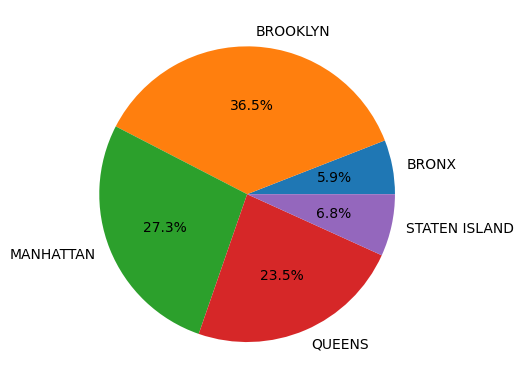

In [ ]:
#amount of data for copper levels based on borough
plt.pie(copper_by_borough[('First Draw at-the-tap copper level (mg/l)', 'size')], labels = copper_by_borough.index, autopct='%1.1f%%');

<ipython-input-23-582d08bc9e2c>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45);
<ipython-input-23-582d08bc9e2c>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(axes[0].get_xticklabels(), rotation=45);


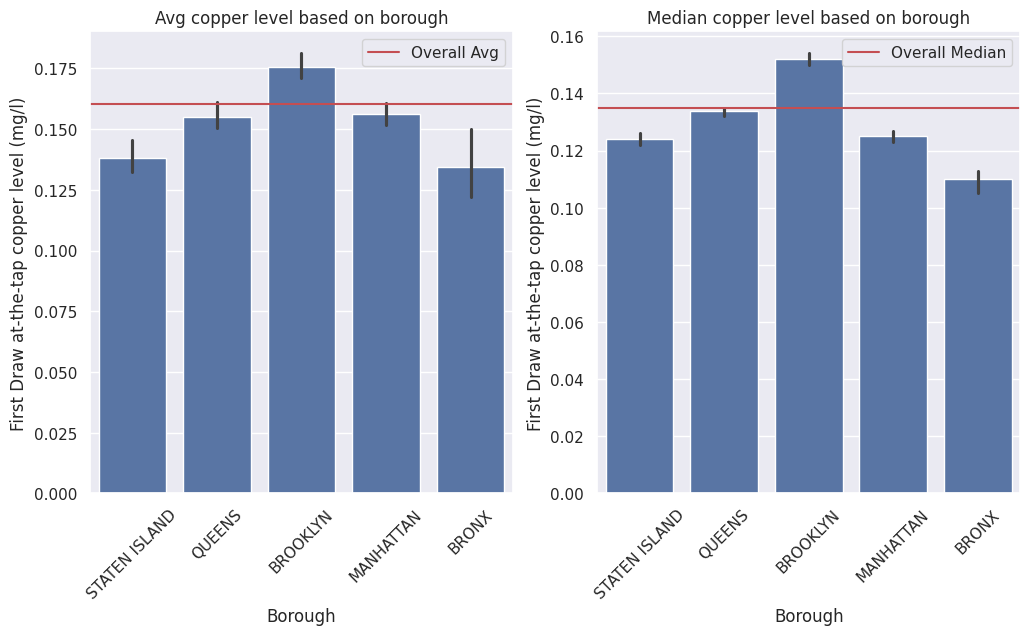

In [ ]:
#plot avg and median copper level based on borough
sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(12,6))
sns.barplot(data=all_first_draw, x='Borough', y='First Draw at-the-tap copper level (mg/l)', estimator=np.mean, ax = axes[0]);
axes[0].axhline(y=copper_all[0], color='r', linestyle='-', label='Overall Avg');
axes[0].set_title('Avg copper level based on borough');
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45);
axes[0].legend();

sns.barplot(data=all_first_draw, x='Borough', y='First Draw at-the-tap copper level (mg/l)', estimator=np.median, ax = axes[1]);
axes[1].axhline(y=copper_all[2], color='r', linestyle='-', label='Overall Median');
axes[1].set_title('Median copper level based on borough');
axes[1].set_xticklabels(axes[0].get_xticklabels(), rotation=45);
axes[1].legend();
plt.show()

Based on the aggregate statistics chart and pie chart, Brooklyn has the most entries on copper level with about 36.5% of the data. In addition, based on the bar graph, Brooklyn has the highest mean (**0.176**) and median (**0.152**) copper level. This mean is even higher than the overall copper level of NYC (**0.160**) and higher than the overall median **(0.135**).
Brooklyn being the densest borough in NYC, this may be a concern for tap water. Queens, the largest borough geographically, has a lower mean (**0.155**) and median (**0.134**) than Brooklyn. This also suggests that Brooklyn may need to check their water regulations.

To further investigate Brooklyn, we'll look at the copper levels throughout the years.

<ipython-input-24-65671e8fa82f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copper_brooklyn['Year'] = copper_brooklyn['Date Collected'].dt.year


<Axes: xlabel='Date Collected', ylabel='First Draw at-the-tap copper level (mg/l)'>

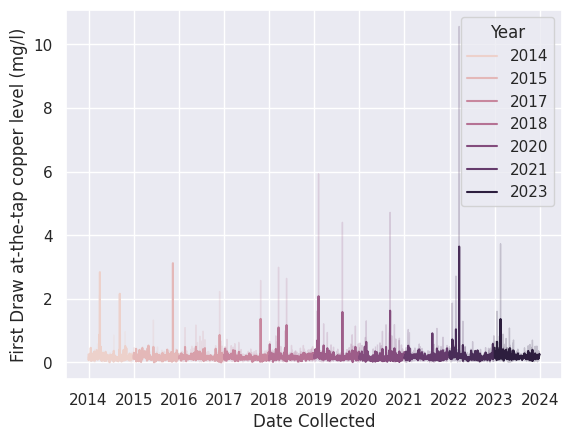

In [ ]:
#further investigate brooklyn
copper_brooklyn = all_first_draw[all_first_draw['Borough'] == 'BROOKLYN']
copper_brooklyn['Year'] = copper_brooklyn['Date Collected'].dt.year

#plot copper level over the years for brooklyn
sns.color_palette("Set2")
sns.lineplot(data=copper_brooklyn, x='Date Collected', y='First Draw at-the-tap copper level (mg/l)', hue='Year')

Based on the time analysis, there seemed to be the largest spike in 2022,
so we can take a look at the statistics based on year.

In [ ]:
#aggregate statistics for copper level over the yrs for brooklyn
copper_brook_yr = copper_brooklyn[['Year', 'First Draw at-the-tap copper level (mg/l)']].groupby('Year').agg(['size', 'mean','std', 'median','min','max'])
copper_brook_yr

First Draw at-the-tap copper level (mg/l)                             \
                                          size      mean       std median   
Year                                                                        
2014                                       404  0.182314  0.218165  0.155   
2015                                       515  0.165031  0.164303  0.147   
2016                                      1995  0.155275  0.134081  0.139   
2017                                      1524  0.163453  0.120587  0.148   
2018                                      1672  0.171874  0.159258  0.152   
2019                                      1760  0.185006  0.382370  0.157   
2020                                      1013  0.154810  0.201714  0.127   
2021                                      1452  0.181465  0.127488  0.165   
2022                                      1646  0.196785  0.705820  0.157   
2023                                      2136  0.188642  0.210463  0.167   

                     
        min     max  
Year                 
2014  0.000   2.840  
2015  0.000   3.121  
2016  0.000   2.307  
2017  0.001   2.579  
2018  0.000   3.941  
2019  0.000  11.381  
2020  0.006   4.718  
2021  0.000   1.776  
2022  0.001  27.739  
2023  0.000   7.237

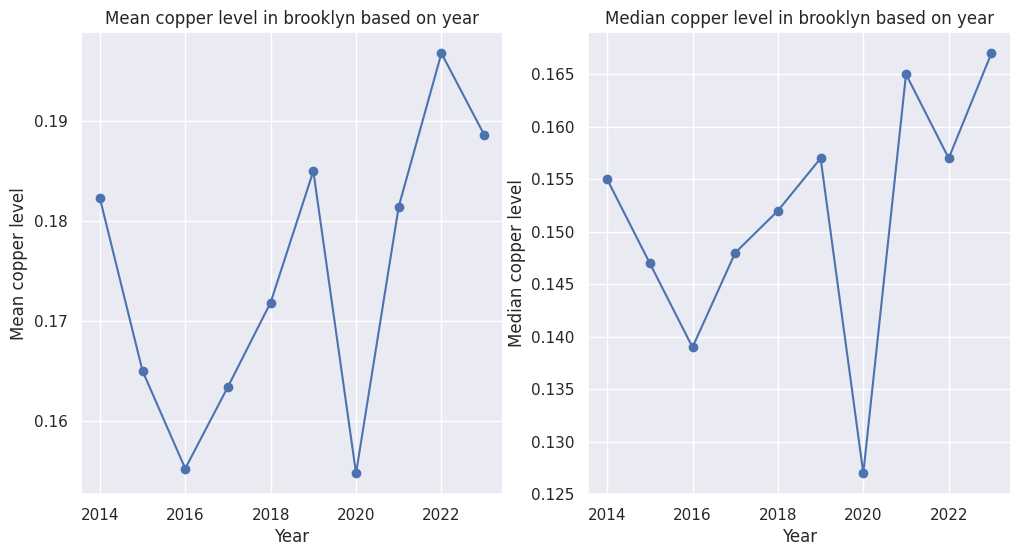

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(12, 6), sharex=True)
# Plotting the average copper levels per year for brooklyn
axes[0].plot(copper_brook_yr.index, copper_brook_yr[('First Draw at-the-tap copper level (mg/l)', 'mean')], label='Average Copper Level', marker='o', linestyle='-')
axes[0].set_title('Mean copper level in brooklyn based on year')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Mean copper level')
#plot median copper level per yr for brooklyn
axes[1].plot(copper_brook_yr.index, copper_brook_yr[('First Draw at-the-tap copper level (mg/l)', 'median')], label='Average Copper Level', marker='o', linestyle='-')
axes[1].set_title('Median copper level in brooklyn based on year')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Median copper level')
plt.show()

Connecting the time lineplot and the aggregrate statistics of Brooklyn over the years, it seems like 2022 did have the highest mean (**0.197**) copper level. It's possible it's an outlier, but it could mean something. Something may have happened to cause a sudden surge of copper level in the tap water. Median wasn't the highest (**0.157**), but still pretty high compared to previous years. On the other hand, 2020 had the lowest mean (**0.155**) and median (**0.127**), which may be connected to COVID-19. For example, most people were in quarantine, so less sewage contamination was in the water system. This can also explain the sudden increase again in 2021, which could be connected to more people going back to work after the pandemic. In addition, it's quite a concern for water regulations because the mean and median copper level remained high after 2020.

<ipython-input-27-4efc7a5b2061>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copper_manhat['Year'] = copper_manhat['Date Collected'].dt.year


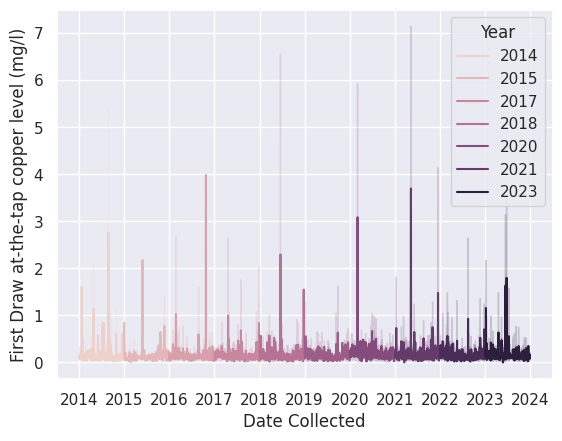

In [ ]:
#investigate manhattan
copper_manhat = all_first_draw[all_first_draw['Borough'] == 'MANHATTAN']
copper_manhat['Year'] = copper_manhat['Date Collected'].dt.year

#plot copper level over the years for manhattan
sns.color_palette(palette='BrBG')
sns.lineplot(data=copper_manhat, x='Date Collected', y='First Draw at-the-tap copper level (mg/l)', hue='Year')
plt.show()

In [ ]:
#aggregate statistics for copper level over the yrs for manhattan
copper_manhat_yr = copper_manhat[['Year', 'First Draw at-the-tap copper level (mg/l)']].groupby('Year').agg(['size', 'mean','std', 'median','min','max'])
copper_manhat_yr

First Draw at-the-tap copper level (mg/l)                              \
                                          size      mean       std  median   
Year                                                                         
2014                                       288  0.184010  0.377900  0.1160   
2015                                       271  0.136930  0.172302  0.1160   
2016                                      1858  0.137747  0.194863  0.1090   
2017                                      1161  0.149191  0.204681  0.1220   
2018                                      1053  0.154024  0.234009  0.1260   
2019                                      1176  0.154250  0.229696  0.1260   
2020                                      1305  0.184975  0.209136  0.1630   
2021                                       941  0.173531  0.355290  0.1330   
2022                                      1041  0.151540  0.222486  0.1160   
2023                                      1458  0.154113  0.190135  0.1265   

                    
        min    max  
Year                
2014  0.017  5.409  
2015  0.007  2.174  
2016  0.003  3.982  
2017  0.005  4.257  
2018  0.000  6.553  
2019  0.000  6.812  
2020  0.001  5.928  
2021  0.002  7.140  
2022  0.000  5.220  
2023  0.000  3.420

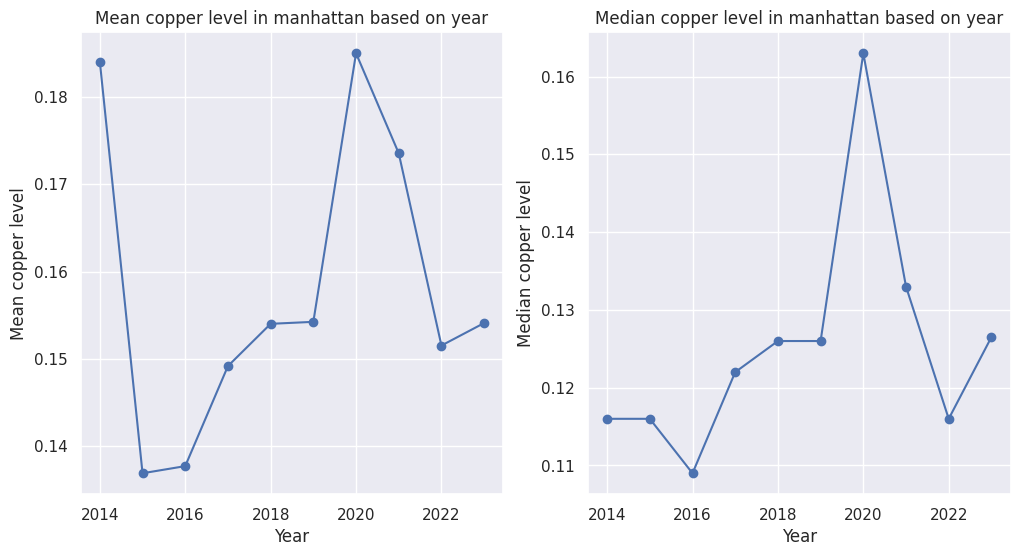

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(12, 6), sharex=True)
# Plotting the average copper levels per year for manhattan
axes[0].plot(copper_manhat_yr.index, copper_manhat_yr[('First Draw at-the-tap copper level (mg/l)', 'mean')], label='Average Copper Level', marker='o', linestyle='-')
axes[0].set_title('Mean copper level in manhattan based on year')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Mean copper level')
#plot median copper level per yr for manhattan
axes[1].plot(copper_manhat_yr.index, copper_manhat_yr[('First Draw at-the-tap copper level (mg/l)', 'median')], label='Average Copper Level', marker='o', linestyle='-')
axes[1].set_title('Median copper level in manhattan based on year')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Median copper level')
plt.show()

Similar to the process with brooklyn, we looked at the copper levels throughout the years. It looks like the opposite of Brooklyn during 2020. For Manhattan, 2020 had the highest mean (**0.185**) and median (**0.163**) copper levels. For 2023, Manhattan remained low, which could mean the water regulations are getting better compared to 2020.

### Lead level analysis

In [ ]:
#lead levels overall
lead_all = all_first_draw['First Draw at-the-tap Lead level (mg/l)'].agg(['mean','std', 'median','min','max'])
lead_all

mean       0.006210
std        0.173299
median     0.000000
min        0.000000
max       17.029000
Name: First Draw at-the-tap Lead level (mg/l), dtype: float64

The aggregate statistics for all NYC lead levels show that the mean is **0.006** and the median is **0**.

In [ ]:
#aggregate stastics on lead based on borough
lead_by_borough = all_first_draw[['Borough', 'First Draw at-the-tap Lead level (mg/l)']].groupby('Borough').agg(['size', 'mean','std', 'median','min','max'])
lead_by_borough

First Draw at-the-tap Lead level (mg/l)                      \
                                                 size      mean       std   
Borough                                                                     
BRONX                                            2292  0.003106  0.022852   
BROOKLYN                                        14117  0.006030  0.119527   
MANHATTAN                                       10552  0.003679  0.149359   
QUEENS                                           9101  0.008825  0.251737   
STATEN ISLAND                                    2623  0.010998  0.236487   

                                   
              median  min     max  
Borough                            
BRONX            0.0  0.0   0.860  
BROOKLYN         0.0  0.0   6.768  
MANHATTAN        0.0  0.0  15.082  
QUEENS           0.0  0.0  17.029  
STATEN ISLAND    0.0  0.0   9.655

<ipython-input-32-8a4114b0c4b1>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(axes.get_xticklabels(), rotation=45);


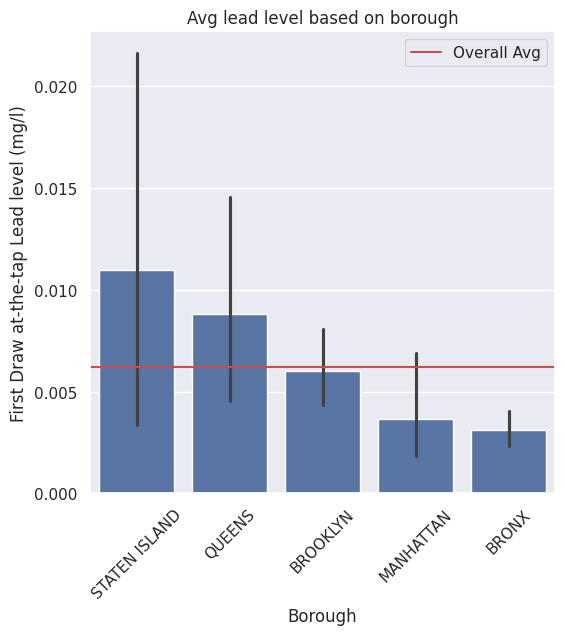

In [ ]:
#plot avg and median lead level based on borough
sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(6,6))
sns.barplot(data=all_first_draw, x='Borough', y='First Draw at-the-tap Lead level (mg/l)', estimator=np.mean, ax = axes);
axes.axhline(y=lead_all[0], color='r', linestyle='-', label='Overall Avg');
axes.set_title('Avg lead level based on borough');
axes.set_xticklabels(axes.get_xticklabels(), rotation=45);
axes.legend();

Since the median lead level was 0, we will just look at the average levels for lead. Using the same pie chart from earlier and this bar graph, Staten Island had the highest average lead level but made up only 6.8% of the samples, so we might need more data from the area to analyze further. Both Staten Island and Queens had lead levels above the average NYC lead levels, so we will look further into Queens, which made up 23.5% of the data but had the second highest average lead level of **0.008**.

<ipython-input-33-0d2b2688ca4e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lead_queens['Year'] = lead_queens['Date Collected'].dt.year


<Axes: xlabel='Date Collected', ylabel='First Draw at-the-tap Lead level (mg/l)'>

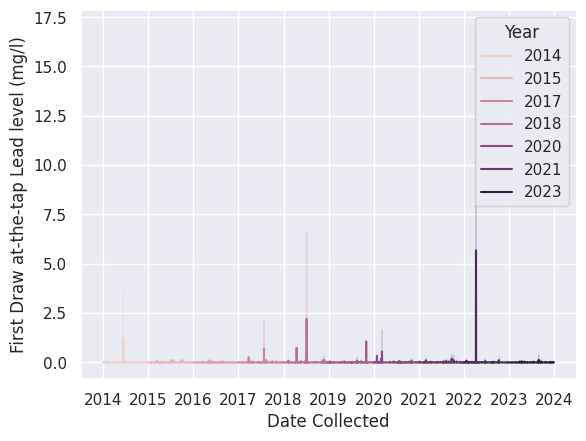

In [ ]:
#further investigate queens
lead_queens = all_first_draw[all_first_draw['Borough'] == 'QUEENS']
lead_queens['Year'] = lead_queens['Date Collected'].dt.year

#plot copper level over the years for brooklyn
sns.color_palette("Set2")
sns.lineplot(data=lead_queens, x='Date Collected', y='First Draw at-the-tap Lead level (mg/l)', hue='Year')

Similar to the copper levels, there appears to be a spike in 2022 for the lead levels, so this could also be related to COVID-19.

In [ ]:
#aggregate statistics for copper level over the yrs for brooklyn
lead_queens_yr = lead_queens[['Year', 'First Draw at-the-tap Lead level (mg/l)']].groupby('Year').agg(['size', 'mean','std', 'median','min','max'])
lead_queens_yr

First Draw at-the-tap Lead level (mg/l)                                  \
                                        size      mean       std median  min   
Year                                                                           
2014                                     279  0.022961  0.297786  0.001  0.0   
2015                                     341  0.005164  0.014174  0.002  0.0   
2016                                    1125  0.003395  0.019168  0.000  0.0   
2017                                     834  0.006783  0.098725  0.000  0.0   
2018                                     992  0.020397  0.492409  0.000  0.0   
2019                                    1068  0.004010  0.036032  0.000  0.0   
2020                                    1002  0.007679  0.099122  0.000  0.0   
2021                                    1110  0.005215  0.035203  0.000  0.0   
2022                                    1245  0.017353  0.482750  0.000  0.0   
2023                                    1105  0.002777  0.014706  0.000  0.0   

              
         max  
Year          
2014   4.960  
2015   0.122  
2016   0.541  
2017   2.826  
2018  15.483  
2019   1.064  
2020   2.766  
2021   0.993  
2022  17.029  
2023   0.381

Text(0, 0.5, 'Mean lead level')

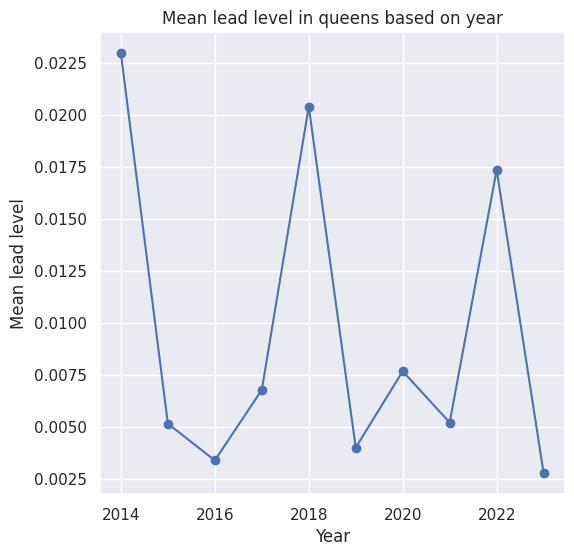

In [ ]:
fig, axes = plt.subplots(1,1, figsize=(6, 6), sharex=True)
# Plotting the average lead levels per year for queens
axes.plot(lead_queens_yr.index, lead_queens_yr[('First Draw at-the-tap Lead level (mg/l)', 'mean')], label='Average Lead Level', marker='o', linestyle='-')
axes.set_title('Mean lead level in queens based on year')
axes.set_xlabel('Year')
axes.set_ylabel('Mean lead level')

For the average lead levels in queens, there were also spikes in 2014 and 2018. This appears to align with the trend in copper levels in Brooklyn that we looked at previously, with spikes in 2014, 2018, and 2022 but lower levels in between those years. The cause of contamination for both lead and copper could be related, so looking into what events were common between those years could provide some insight.

#Relationship between copper and lead levels

According to the U.S. Environmental Protection Agency, the maximum levels of lead and copper in drinking water is **0.015 and 1.3** (below which there is no known or expected risk to health). After some intial graphs, copper levels were much lower than 1.3 mg/L which made it difficult to see variations in data when plotted with the line, so we will use the "acceptable" level of 0.5 rather than 1.3 for visibility purposes.

In [ ]:
safe_lead_lvl = 0.015
safe_copper_lvl = 0.5

We will look at the yearly average copper and lead levels to see if their trends are related.

<ipython-input-37-8e27016f4a29>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bronx_data['Year'] = bronx_data['Date Collected'].dt.year


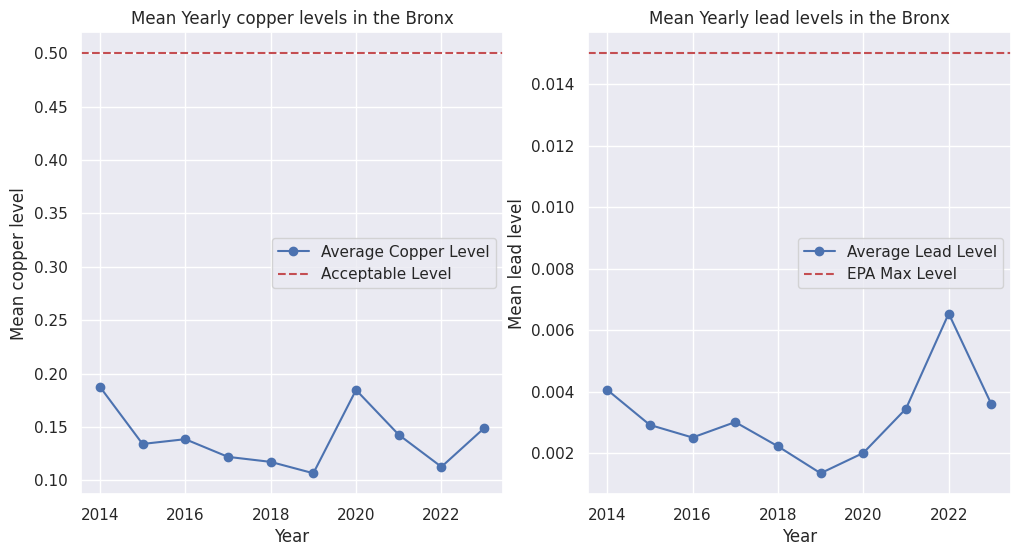

In [ ]:
# Bronx
fig, axes = plt.subplots(1,2, figsize=(12,6), sharex=True)
bronx_data = all_first_draw[all_first_draw['Borough'] == 'BRONX']
bronx_data['Year'] = bronx_data['Date Collected'].dt.year
bronx_by_yr = bronx_data[['Year', 'First Draw at-the-tap copper level (mg/l)','First Draw at-the-tap Lead level (mg/l)']].groupby('Year').mean()
axes[0].plot(bronx_by_yr.index, bronx_by_yr['First Draw at-the-tap copper level (mg/l)'], label='Average Copper Level', marker='o', linestyle='-')
axes[0].axhline(y=safe_copper_lvl, color='r', linestyle='--', label='Acceptable Level');
axes[0].set_title('Mean Yearly copper levels in the Bronx')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Mean copper level')
axes[0].legend()
axes[1].plot(bronx_by_yr.index, bronx_by_yr['First Draw at-the-tap Lead level (mg/l)'], label='Average Lead Level', marker='o', linestyle='-')
axes[1].axhline(y=safe_lead_lvl, color='r', linestyle='--', label='EPA Max Level');
axes[1].set_title('Mean Yearly lead levels in the Bronx')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Mean lead level')
axes[1].legend()
plt.show()

<ipython-input-38-4071038b81fe>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  brooklyn_data['Year'] = brooklyn_data['Date Collected'].dt.year


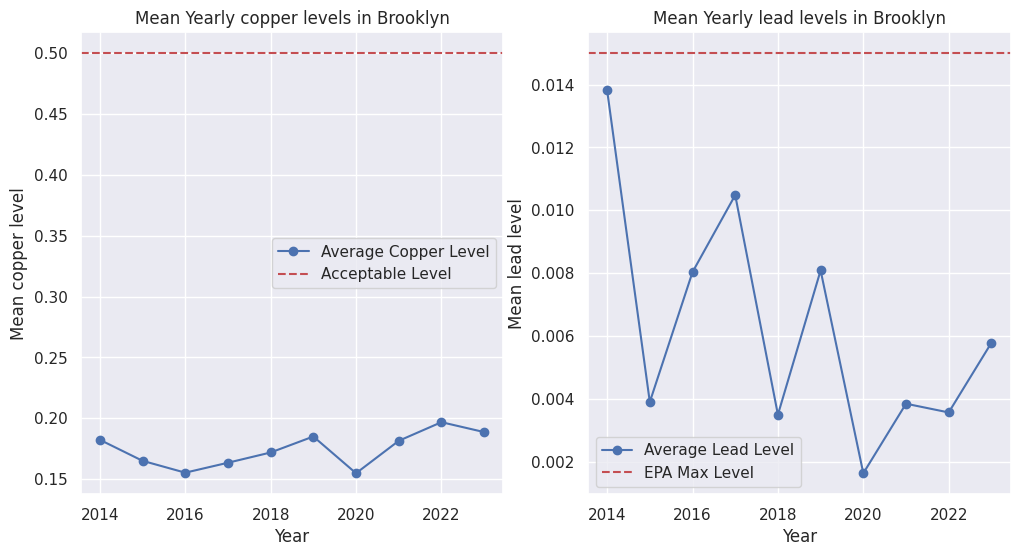

In [ ]:
# Brooklyn
fig, axes = plt.subplots(1,2, figsize=(12,6), sharex=True)
brooklyn_data = all_first_draw[all_first_draw['Borough'] == 'BROOKLYN']
brooklyn_data['Year'] = brooklyn_data['Date Collected'].dt.year
brook_by_yr = brooklyn_data[['Year', 'First Draw at-the-tap copper level (mg/l)','First Draw at-the-tap Lead level (mg/l)']].groupby('Year').mean()
axes[0].plot(brook_by_yr.index, brook_by_yr['First Draw at-the-tap copper level (mg/l)'], label='Average Copper Level', marker='o', linestyle='-')
axes[0].axhline(y=safe_copper_lvl, color='r', linestyle='--', label='Acceptable Level');
axes[0].set_title('Mean Yearly copper levels in Brooklyn')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Mean copper level')
axes[0].legend()
axes[1].plot(brook_by_yr.index, brook_by_yr['First Draw at-the-tap Lead level (mg/l)'], label='Average Lead Level', marker='o', linestyle='-')
axes[1].axhline(y=safe_lead_lvl, color='r', linestyle='--', label='EPA Max Level');
axes[1].set_title('Mean Yearly lead levels in Brooklyn')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Mean lead level')
axes[1].legend()
plt.show()

<ipython-input-39-c08a814ca37e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  manhattan_data['Year'] = manhattan_data['Date Collected'].dt.year


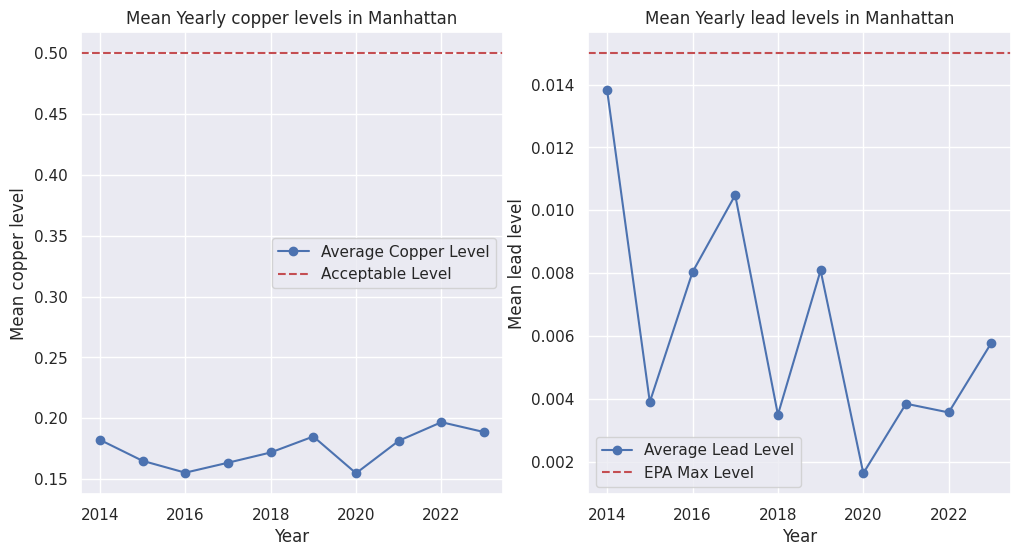

In [ ]:
# Manhattan
fig, axes = plt.subplots(1,2, figsize=(12,6), sharex=True)
manhattan_data = all_first_draw[all_first_draw['Borough'] == 'MANHATTAN']
manhattan_data['Year'] = manhattan_data['Date Collected'].dt.year
mhtn_by_yr = brooklyn_data[['Year', 'First Draw at-the-tap copper level (mg/l)','First Draw at-the-tap Lead level (mg/l)']].groupby('Year').mean()
axes[0].plot(mhtn_by_yr.index, mhtn_by_yr['First Draw at-the-tap copper level (mg/l)'], label='Average Copper Level', marker='o', linestyle='-')
axes[0].axhline(y=safe_copper_lvl, color='r', linestyle='--', label='Acceptable Level');
axes[0].set_title('Mean Yearly copper levels in Manhattan')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Mean copper level')
axes[0].legend()
axes[1].plot(mhtn_by_yr.index, mhtn_by_yr['First Draw at-the-tap Lead level (mg/l)'], label='Average Lead Level', marker='o', linestyle='-')
axes[1].axhline(y=safe_lead_lvl, color='r', linestyle='--', label='EPA Max Level');
axes[1].set_title('Mean Yearly lead levels in Manhattan')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Mean lead level')
axes[1].legend()
plt.show()

<ipython-input-40-f96f6ecc29f1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  queens_data['Year'] = queens_data['Date Collected'].dt.year


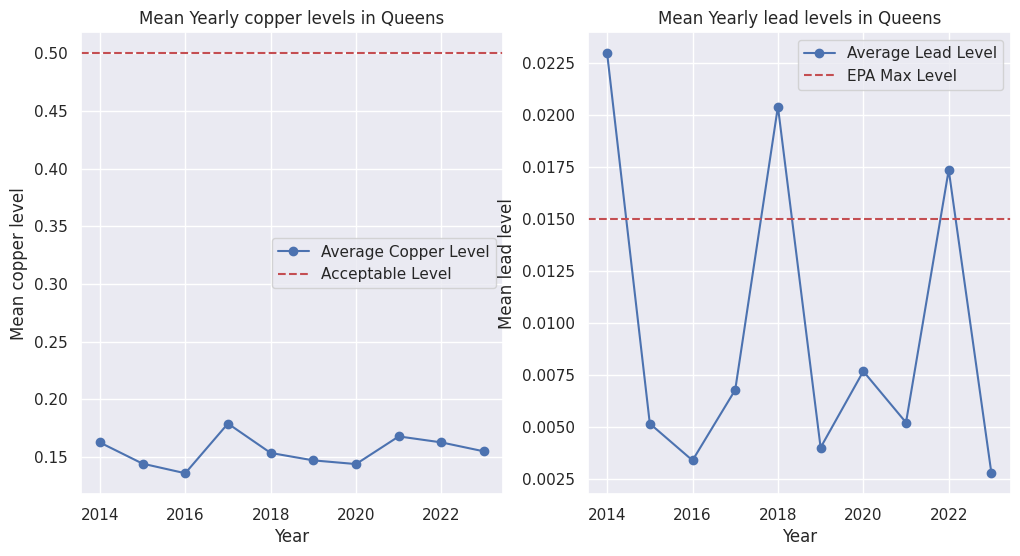

In [ ]:
# Queens
fig, axes = plt.subplots(1,2, figsize=(12,6), sharex=True)
queens_data = all_first_draw[all_first_draw['Borough'] == 'QUEENS']
queens_data['Year'] = queens_data['Date Collected'].dt.year
queens_by_yr = queens_data[['Year', 'First Draw at-the-tap copper level (mg/l)','First Draw at-the-tap Lead level (mg/l)']].groupby('Year').mean()
axes[0].plot(queens_by_yr.index, queens_by_yr['First Draw at-the-tap copper level (mg/l)'], label='Average Copper Level', marker='o', linestyle='-')
axes[0].axhline(y=safe_copper_lvl, color='r', linestyle='--', label='Acceptable Level');
axes[0].set_title('Mean Yearly copper levels in Queens')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Mean copper level')
axes[0].legend()
axes[1].plot(queens_by_yr.index, queens_by_yr['First Draw at-the-tap Lead level (mg/l)'], label='Average Lead Level', marker='o', linestyle='-')
axes[1].axhline(y=safe_lead_lvl, color='r', linestyle='--', label='EPA Max Level');
axes[1].set_title('Mean Yearly lead levels in Queens')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Mean lead level')
axes[1].legend()
plt.show()

<ipython-input-41-04fc66adcdcc>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stat_isl_data['Year'] = stat_isl_data['Date Collected'].dt.year


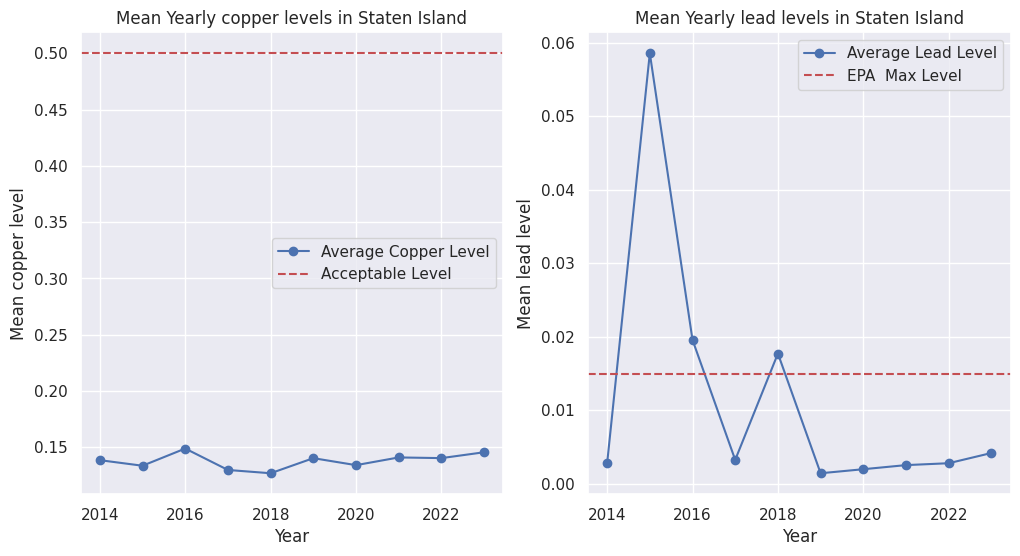

In [ ]:
# Staten Island
fig, axes = plt.subplots(1,2, figsize=(12,6), sharex=True)
stat_isl_data = all_first_draw[all_first_draw['Borough'] == 'STATEN ISLAND']
stat_isl_data['Year'] = stat_isl_data['Date Collected'].dt.year
stat_isl_by_yr = stat_isl_data[['Year', 'First Draw at-the-tap copper level (mg/l)','First Draw at-the-tap Lead level (mg/l)']].groupby('Year').mean()
axes[0].plot(stat_isl_by_yr.index, stat_isl_by_yr['First Draw at-the-tap copper level (mg/l)'], label='Average Copper Level', marker='o', linestyle='-')
axes[0].axhline(y=safe_copper_lvl, color='r', linestyle='--', label='Acceptable Level');
axes[0].set_title('Mean Yearly copper levels in Staten Island')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Mean copper level')
axes[0].legend()
axes[1].plot(stat_isl_by_yr.index, stat_isl_by_yr['First Draw at-the-tap Lead level (mg/l)'], label='Average Lead Level', marker='o', linestyle='-')
axes[1].axhline(y=safe_lead_lvl, color='r', linestyle='--', label='EPA  Max Level');
axes[1].set_title('Mean Yearly lead levels in Staten Island')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Mean lead level')
axes[1].legend()
plt.show()

Across all boroughs, copper levels remain below the acceptable safe levels recommended by the EPA. However, lead levels reach much closer to the safe level, and actually went above the safe level in Queens and Staten Island. In Queens, the average lead levels were above the safe level in 2014, 2018, and 2022. It decreased in 2023, but this is concerning if the lead levels continue to follow a trend of rising again after declining. In Staten Island, the average lead level peaked in 2015, above the safe level, but has declined since then.

In [ ]:
stats.pearsonr(all_first_draw['First Draw at-the-tap copper level (mg/l)'], all_first_draw['First Draw at-the-tap Lead level (mg/l)'])

PearsonRResult(statistic=0.09590197946311546, pvalue=1.028378219525621e-79)

While there seemed to be some similarities between the trend in copper levels and lead levels in water samples, the R statistic is 0.096, so the relationship is very weak. The lead levels fluctuate a lot more, while copper levels tend to remain in a similar range. This shows that we cannot rely on copper or lead level as an indicator for the other, and samples should be tested for both independently. Lead levels are especially of concern for NYC water samples.

# Machine Learning

In [ ]:
#attempt at classification
data = all_first_draw

#function to classify copper levels to safe or danger
def copper_label(value):
  label = ''
  if value <= safe_copper_lvl:
    label = 'Safe'
    return label
  else:
    label = 'Danger'
    return label
#function to classify lead levels to safe or danger
def lead_label(value):
  label = ''
  if value <= safe_lead_lvl:
    label='Safe'
    return label
  else:
    label='Danger'
    return label
#apply function to columns
data['Copper Label'] = data['First Draw at-the-tap copper level (mg/l)'].apply(copper_label)
data['Lead Label'] = data['First Draw at-the-tap Lead level (mg/l)'].apply(lead_label)

First we labeled the copper and lead levels based on the EPA safety threshold.

In [ ]:
data['Year'] = data['Date Collected'].dt.year
data['Month'] = data['Date Collected'].dt.month
data['Day'] = data['Date Collected'].dt.day
data.drop(columns=['Date Collected', 'Received Date'], inplace=True)

In [ ]:
#turn categorical labels into numerical labels
encoder = LabelEncoder()
data['Borough'] = encoder.fit_transform(data['Borough'])
data['Copper Label'] = encoder.fit_transform(data['Copper Label'])
data['Lead Label'] = encoder.fit_transform(data['Lead Label'])

In [ ]:
#one hot encoding for zipcode
zips = LabelBinarizer().fit_transform(data['Zipcode'])
temp = pd.DataFrame(zips, columns = sorted(data.Zipcode.unique()))
data = pd.concat([data,temp], axis=1)

In [ ]:
data.columns = data.columns.astype(str)

Then, we extracted the datetime objects into separate columns because classifier models usually take in numerical values. In addition, we turned the categorical variables into numerical values along with binarizing the zipcodes because zipcodes are technically categorical.

We will test a random forest model instead of a KNN model because there's a lot of categorical variables and random forest would be better for more complex relationships.

In [ ]:
#determine x and y for copper classifier
X_copper = data.drop(columns=['Zipcode', 'First Draw at-the-tap copper level (mg/l)', 'Copper Label','Lead Label'])
y_copper = data['Copper Label']

#split data into train and test set
X_copper_train, X_copper_test, y_copper_train, y_copper_test = train_test_split(X_copper, y_copper, test_size=0.2, random_state=42)

#train model using random forest
copper_rf_model = RandomForestClassifier(random_state=42)
copper_rf_model.fit(X_copper_train, y_copper_train)

#test model with test set
y_copper_pred = copper_rf_model.predict(X_copper_test)

#print accuracy
print(accuracy_score(y_copper_test, y_copper_pred))
print(classification_report(y_copper_test, y_copper_pred))

0.9857826030761278
              precision    recall  f1-score   support

           0       0.50      0.02      0.04       110
           1       0.99      1.00      0.99      7627

    accuracy                           0.99      7737
   macro avg       0.74      0.51      0.51      7737
weighted avg       0.98      0.99      0.98      7737



Text(46.25, 0.5, 'True Labels')

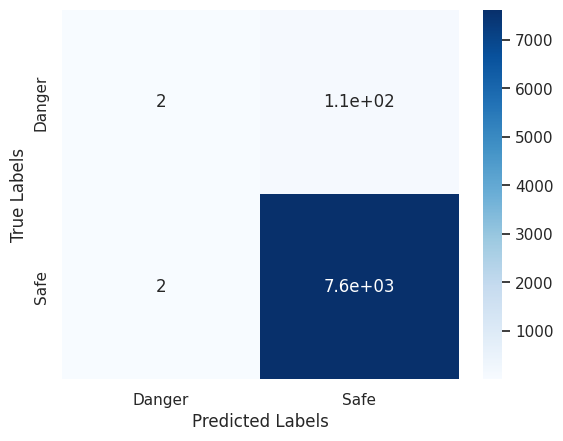

In [ ]:
cm = confusion_matrix(y_copper_test, y_copper_pred)
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=['Danger', 'Safe'], yticklabels=['Danger', 'Safe'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

Based on the results, the accuracy was **0.986**, which is very high. This may be an overfitting problem. In addition, the model did better at classifying copper level as 'safe.' Based on the heatmap, the model predicted **7600** instances correctly. This means that the instances that were predicted safe was actually safe. However, the number of false positives was **110**, which is pretty high. In this case, this means the instances that were actually dangerous were predicted as safe. That could be problematic because underlying water problems won't be detected if this model was used.

The number of instances that were predicted as dangerous and were actually dangerous was only 2. Similarly, the number of instances that were predicted as dangerous but were actually safe was 2.

Similarly, we'll test a model of classifying lead levels.

In [ ]:
#determine x and y for lead classifier
X_lead = data.drop(columns=['Zipcode', 'First Draw at-the-tap Lead level (mg/l)', 'Copper Label','Lead Label'])
y_lead = data['Lead Label']

#split data into train and test set
X_lead_train, X_lead_test, y_lead_train, y_lead_test = train_test_split(X_lead, y_lead, test_size=0.2, random_state=42)

#train model using random forest
lead_rf_model = RandomForestClassifier(random_state=42)
lead_rf_model.fit(X_lead_train, y_lead_train)

#test model with test set
y_lead_pred = lead_rf_model.predict(X_lead_test)

#print accuracy
print(accuracy_score(y_lead_test, y_lead_pred))
print(classification_report(y_lead_test, y_lead_pred))

0.972728447718754
              precision    recall  f1-score   support

           0       0.54      0.03      0.06       212
           1       0.97      1.00      0.99      7525

    accuracy                           0.97      7737
   macro avg       0.76      0.52      0.52      7737
weighted avg       0.96      0.97      0.96      7737



Text(46.25, 0.5, 'True Labels')

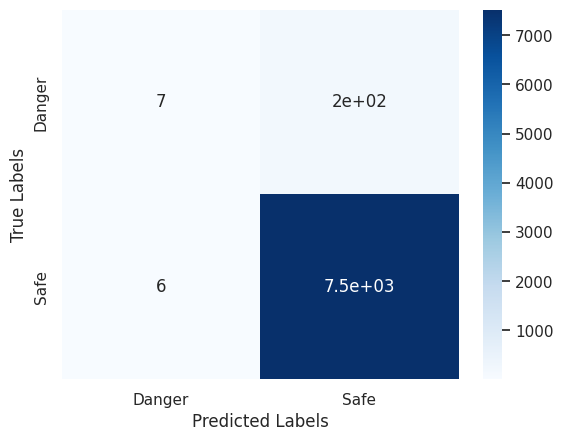

In [ ]:
cm_1 = confusion_matrix(y_lead_test, y_lead_pred)
sns.heatmap(cm_1, annot=True, cmap='Blues', xticklabels=['Danger', 'Safe'], yticklabels=['Danger', 'Safe'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

It seems like the accuracy of **0.973** is still pretty high, which could also indicate an overfitting issue. Similar to the copper level model, this one did well in the true positive classification, which was **7500** instances. However, this model did worse because it classified **200** instances being safe when it was actually dangerous.

Overall, both models had a hard time classifying the true dangerous instances correctly. This error may indicate that we don't have enough data on dangerous copper and lead levels to train the model properly. However, it could be a good thing that we don't because if we did have a lot of data on dangerous levels of copper and lead that would indicate the water systems are problematic.

Open issues could be this may not generalize to other cities and because of the overfitting problem, it won't represent out of distribution data well.